## Bayesian Neural Networks in PyMC3

Источники:

. [Automatic Differentiation Variational Inference. Alp Kucukelbir et al.](https://arxiv.org/pdf/1603.00788.pdf)

. [Understanding Variational Inference](http://kronosapiens.github.io/blog/2015/11/22/understanding-variational-inference.html)

. [Блог Бармалея](http://barmaley-exe.github.io/)

### Generating data

First, lets generate some toy data -- a simple binary classification problem that's not linearly separable.

In [2]:
%matplotlib inline
import pymc3 as pm
import theano.tensor as T
import theano
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons, make_circles

import lasagne

Couldn't import dot_parser, loading of dot files will not be possible.


In [207]:
def moons(n=1000, noise=0.2):
    X, Y = make_moons(n_samples=n, noise=noise, random_state=0)
    X = scale(X)
    return train_test_split(X, Y, test_size=.5)

def circles(n=1000, noise=0.2):
    X, Y = make_circles(n_samples=n, noise=noise, random_state=0, factor=0.3)
    X = scale(X)
    return train_test_split(X, Y, test_size=.5) 

def line(n=1000, noise=0.2):
    X = np.random.random((n, 2))
    Y = np.array([int(x[0] - x[1] > np.random.random()*noise) for x in X])
    X = scale(X)
    return train_test_split(X, Y, test_size=.5) 
    
X_train, X_test, Y_train, Y_test = circles()

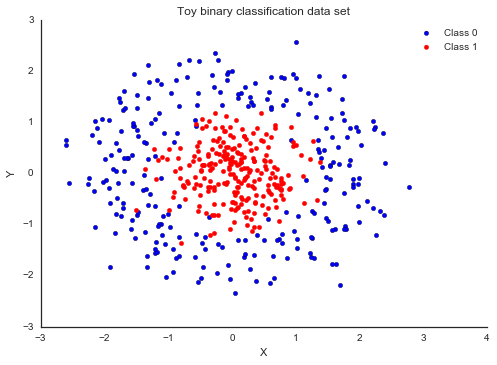

In [208]:
fig, ax = plt.subplots()
ax.scatter(X_train[Y_train==0, 0], X_train[Y_train==0, 1], label='Class 0')
ax.scatter(X_train[Y_train==1, 0], X_train[Y_train==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

### Model specification

A neural network is quite simple. The basic unit is a [perceptron](https://en.wikipedia.org/wiki/Perceptron) which is nothing more than [logistic regression](http://pymc-devs.github.io/pymc3/notebooks/posterior_predictive.html#Prediction). We use many of these in parallel and then stack them up to get hidden layers. Here we will use 2 hidden layers with 5 neurons each which is sufficient for such a simple problem.

In [209]:
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

m = X_train.shape[1]

n_hidden = 10

# Initialize random weights between each layer
init_1 = np.random.randn(m, n_hidden)
init_b_1 = np.random.randn(n_hidden)
init_2 = np.random.randn(n_hidden, n_hidden)
init_b_2 = np.random.randn(n_hidden)
init_out = np.random.randn(n_hidden, 1)
init_b_out = np.random.randn(1)
    
with pm.Model() as neural_network:
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, shape=(m, n_hidden), testval=init_1)
    b_1 = pm.Normal('b_1', 0, sd=1, shape=n_hidden, testval=init_b_1)
    
    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1, shape=(n_hidden, n_hidden), testval=init_2)
    b_2 = pm.Normal('b_2', 0, sd=1, shape=n_hidden, testval=init_b_2)
    
    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1, shape=(n_hidden, 1), testval=init_out)
    b_out = pm.Normal('b_out', 0, sd=1, shape=1, testval=init_b_out)
    
    # Build neural-network using tanh activation function
    act_in = lasagne.layers.InputLayer(X_train.shape, input_var=ann_input)
    
    act_1 = lasagne.layers.DenseLayer(act_in, n_hidden, W=weights_in_1, b=b_1, nonlinearity=lasagne.nonlinearities.tanh)
    act_2 = lasagne.layers.DenseLayer(act_1, n_hidden, W=weights_1_2, b=b_2, nonlinearity=lasagne.nonlinearities.tanh)    
    act_out = lasagne.layers.DenseLayer(act_2, 1, W=weights_2_out, b=b_out, nonlinearity=lasagne.nonlinearities.sigmoid)
    
    net_out = lasagne.layers.get_output(act_out)
    
    # Binary classification -> Bernoulli likelihood
    out = pm.Bernoulli('out', net_out.flatten(), observed=ann_output)

### Variational Inference: Scaling model complexity

We could now just run a MCMC sampler like [`NUTS`](http://pymc-devs.github.io/pymc3/api.html#nuts) which works pretty well in this case but as I already mentioned, this will become very slow as we scale our model up to deeper architectures with more layers.

Instead, we will use the brand-new [ADVI](http://pymc-devs.github.io/pymc3/api.html#advi) variational inference algorithm which was recently added to `PyMC3`. This is much faster and will scale better. Note, that this is a mean-field approximation so we ignore correlations in the posterior.

In [210]:
%%time

with neural_network:
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    v_params = pm.variational.advi(n=100000)

Iteration 0 [0%]: ELBO = -744.07
Iteration 10000 [10%]: Average ELBO = -699.17
Iteration 20000 [20%]: Average ELBO = -381.98
Iteration 30000 [30%]: Average ELBO = -288.95
Iteration 40000 [40%]: Average ELBO = -244.73
Iteration 50000 [50%]: Average ELBO = -223.51
Iteration 60000 [60%]: Average ELBO = -210.66
Iteration 70000 [70%]: Average ELBO = -202.48
Iteration 80000 [80%]: Average ELBO = -196.05
Iteration 90000 [90%]: Average ELBO = -189.36
Finished [100%]: Average ELBO = -183.44
CPU times: user 1min 12s, sys: 9.87 s, total: 1min 21s
Wall time: 1min 23s


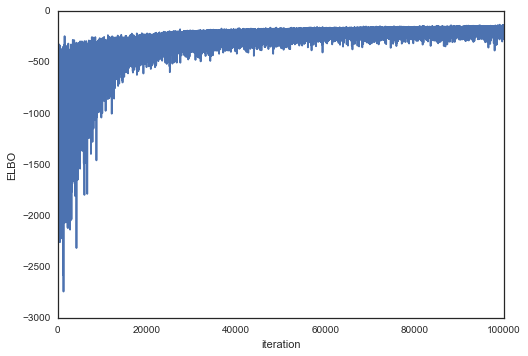

In [211]:
plt.plot(v_params.elbo_vals)
plt.ylabel('ELBO')
plt.xlabel('iteration')

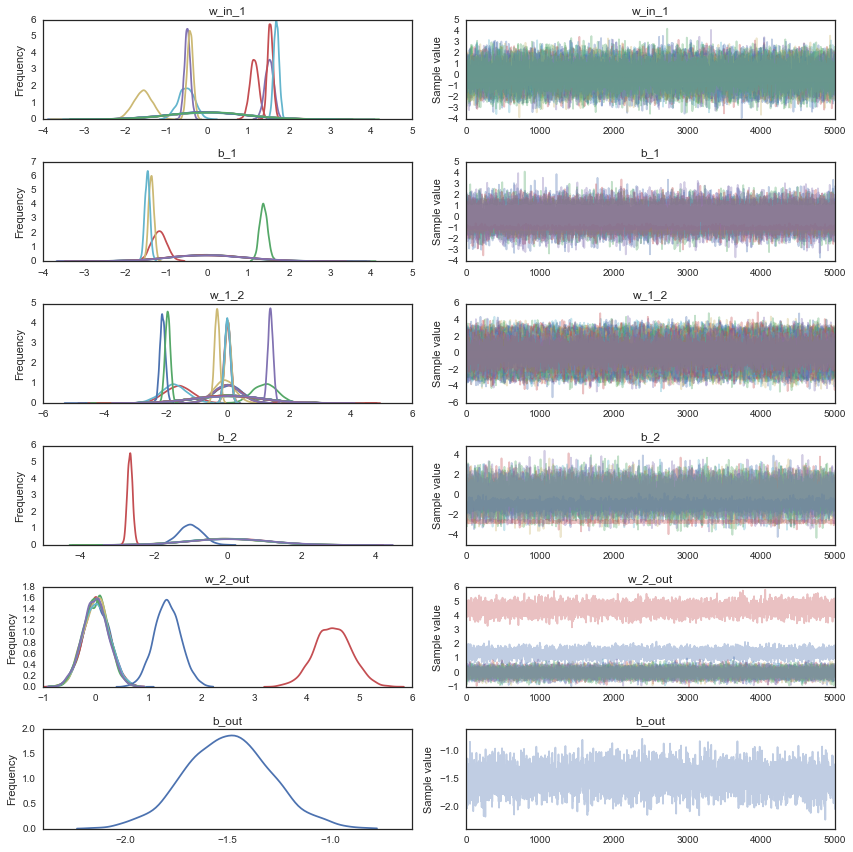

In [212]:
with neural_network:
    trace = pm.variational.sample_vp(v_params, draws=5000)
    
    pm.traceplot(trace)

Now that we trained our model, lets predict on the hold-out set using a posterior predictive check (PPC). We use [`sample_ppc()`](http://pymc-devs.github.io/pymc3/api.html#pymc3.sampling.sample_ppc) to generate new data (in this case class predictions) from the posterior (sampled from the variational estimation).

In [213]:
# Replace shared variables with testing set
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

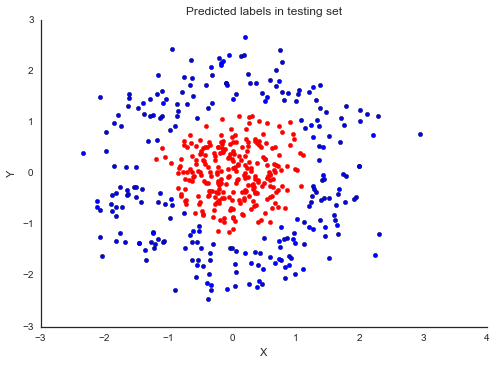

In [214]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [215]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 95.0%


## Lets look at what the classifier has learned

For this, we evaluate the class probability predictions on a grid over the whole input space.

In [174]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [175]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

### Probability surface

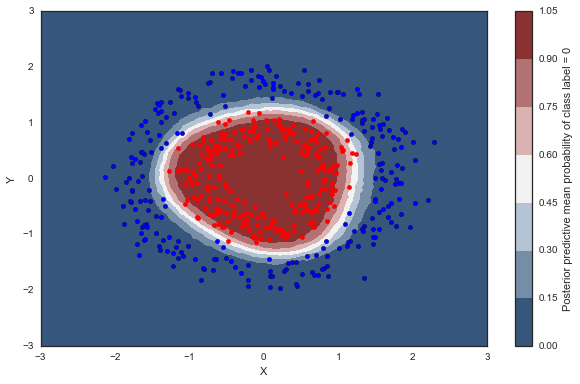

In [176]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0], grid[1], ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

### Uncertainty in predicted value

So far, everything I showed we could have done with a non-Bayesian Neural Network. The mean of the posterior predictive for each class-label should be identical to maximum likelihood predicted values. However, we can also look at the standard deviation of the posterior predictive to get a sense for the uncertainty in our predictions. Here is what that looks like:

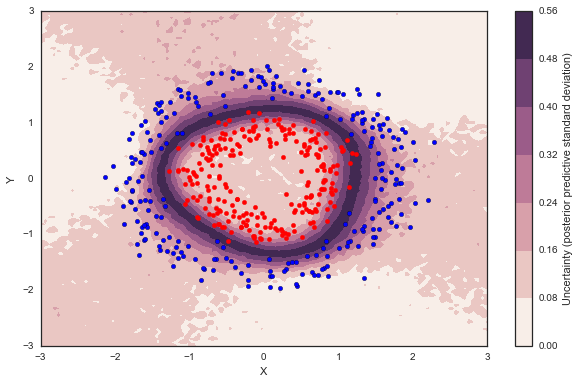

In [177]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0], grid[1], ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');